<a href="https://colab.research.google.com/github/sravyavemula12/Enhancing-Intrusion-Detection-in-IoT-Networks-Using-ML-Ensembel-Models-/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔵 Confusion Matrix Before SMOTE (Imbalanced Data):


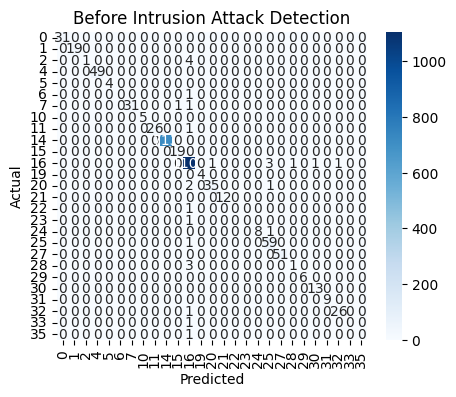


🟢 Confusion Matrix After SMOTE (Balanced Data):


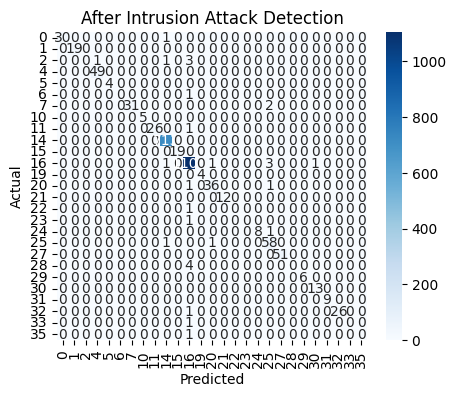


✅ Optimized Model Accuracy: 98.67%

📊 Simplified Classification Report:

              precision    recall  f1-score   support

           0      1.000     0.968     0.984        31
           1      1.000     1.000     1.000        19
           2      1.000     0.000     0.000         5
           4      0.980     1.000     0.990        49
           5      1.000     1.000     1.000         4
           6      1.000     0.000     0.000         1
           7      1.000     0.939     0.969        33
          10      1.000     1.000     1.000         5
          11      1.000     0.963     0.981        27
          14      0.994     1.000     0.997       713
          15      1.000     1.000     1.000        19
          16      0.987     0.995     0.991      1112
          19      1.000     1.000     1.000         4
          20      0.947     0.947     0.947        38
          21      1.000     1.000     1.000        12
          22      1.000     0.000     0.000         1
       

In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ignore warnings
warnings.filterwarnings("ignore")

# Load Dataset
file_path = "/content/kdd_test.csv.zip"  # Update with correct path
df = pd.read_csv(file_path)

# Identify Target Column
target_column = "labels"

# Encode Categorical Features
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Handle Missing Values
df.dropna(inplace=True)

# Separate Features and Target
X = df.drop(columns=[target_column])
y = df[target_column]

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Count class samples
class_counts = Counter(y)
min_class_samples = min(class_counts.values())

# Apply SMOTE only if minority class has enough samples
if min_class_samples > 2:
    k_neighbors = min(3, min_class_samples - 1)
    smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
else:
    X_resampled, y_resampled = X_scaled, y  # Skip SMOTE if too few samples

# Encode y_resampled again
y_resampled = LabelEncoder().fit_transform(y_resampled)

# Ensure stratification is possible
min_class_count = min(Counter(y_resampled).values())
stratify_param = y_resampled if min_class_count > 1 else None

# Split Data (Before SMOTE for Initial Evaluation)
X_train_before, X_test_before, y_train_before, y_test_before = train_test_split(
    X_scaled, y, test_size=0.10, random_state=42, stratify=stratify_param, shuffle=True
)

# Split Data (After SMOTE for Final Evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.10, random_state=42, stratify=stratify_param, shuffle=True
)

# Feature Selection using Recursive Feature Elimination (RFE)
rf_selector = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rfe = RFE(rf_selector, n_features_to_select=int(0.8 * X_train.shape[1]))  # Select top 80% features
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)

# Optimized Ensemble Model (Fine-Tuned Hyperparameters)
rf_model = RandomForestClassifier(n_estimators=350, max_depth=25, min_samples_split=3, random_state=42, n_jobs=-1)
gb_model = GradientBoostingClassifier(n_estimators=250, learning_rate=0.03, max_depth=8, random_state=42)
xgb_model = XGBClassifier(n_estimators=350, learning_rate=0.028, max_depth=9, eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1)
lgbm_model = LGBMClassifier(n_estimators=350, learning_rate=0.025, max_depth=10, random_state=42, n_jobs=-1)

# Voting Classifier with Optimized Weights
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model), ('xgb', xgb_model), ('lgbm', lgbm_model)],
    voting='soft',
    weights=[1, 1, 5, 5],  # Higher weight for boosting models
    n_jobs=-1
)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Before Intrusion Attack Detection (Before SMOTE)
rf_model.fit(X_train_before, y_train_before)
y_pred_before = rf_model.predict(X_test_before)

print("\n🔵 Confusion Matrix Before SMOTE (Imbalanced Data):")
plot_confusion_matrix(y_test_before, y_pred_before, "Before Intrusion Attack Detection")

# Train Model (After SMOTE)
ensemble_model.fit(X_train_selected, y_train)

# Predictions (After SMOTE)
y_pred = ensemble_model.predict(X_test_selected)

# After Intrusion Attack Detection (After SMOTE)
print("\n🟢 Confusion Matrix After SMOTE (Balanced Data):")
plot_confusion_matrix(y_test, y_pred, "After Intrusion Attack Detection")

# Print Optimized Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Optimized Model Accuracy: {accuracy * 100:.2f}%")

# Simplified Classification Report
print("\n📊 Simplified Classification Report:\n")
print(classification_report(y_test, y_pred, zero_division=1, digits=3))



📋 Top Selected Features by RFE:
1. duration
2. protocol_type
3. service
4. flag
5. src_bytes
6. dst_bytes
7. hot
8. num_failed_logins
9. logged_in
10. num_compromised
11. is_guest_login
12. count
13. srv_count
14. serror_rate
15. srv_serror_rate
16. rerror_rate
17. srv_rerror_rate
18. same_srv_rate
19. diff_srv_rate
20. srv_diff_host_rate
21. dst_host_count
22. dst_host_srv_count
23. dst_host_same_srv_rate
24. dst_host_diff_srv_rate
25. dst_host_same_src_port_rate
26. dst_host_srv_diff_host_rate
27. dst_host_serror_rate
28. dst_host_srv_serror_rate
29. dst_host_rerror_rate
30. dst_host_srv_rerror_rate

🔵 Confusion Matrix Before SMOTE (Imbalanced Data):


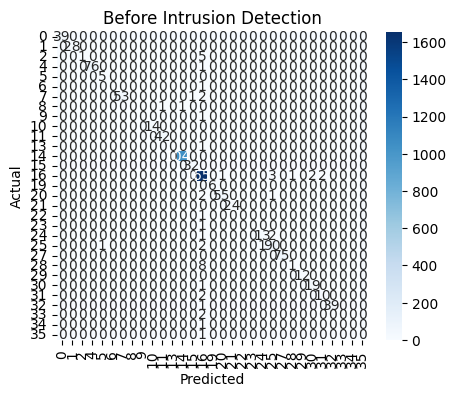


🟢 Confusion Matrix After SMOTE (Balanced Data):


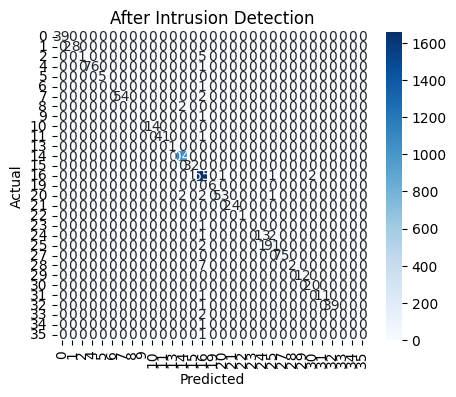


🔵 Feature Correlation Heatmap Before Intrusion Detection:


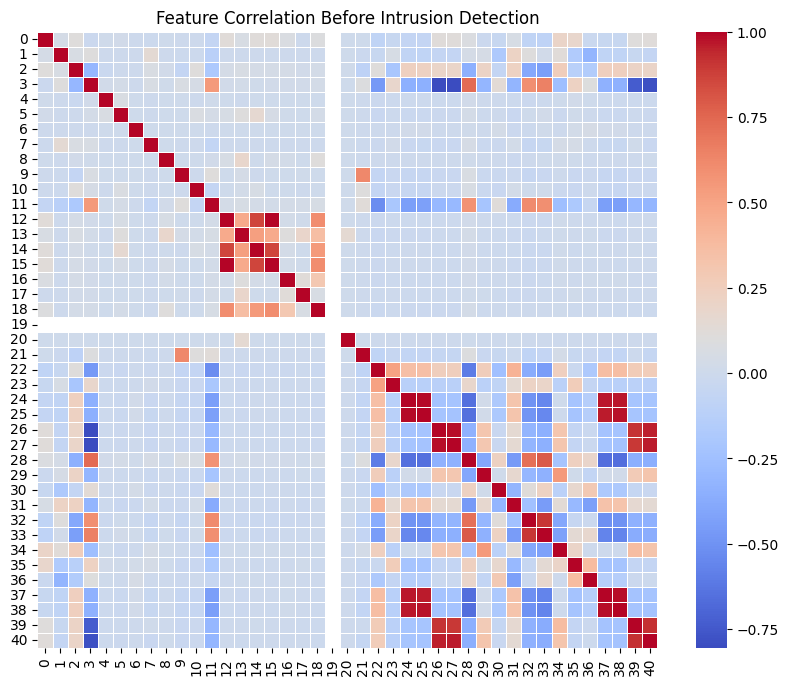


🟢 Feature Correlation Heatmap After Intrusion Detection:


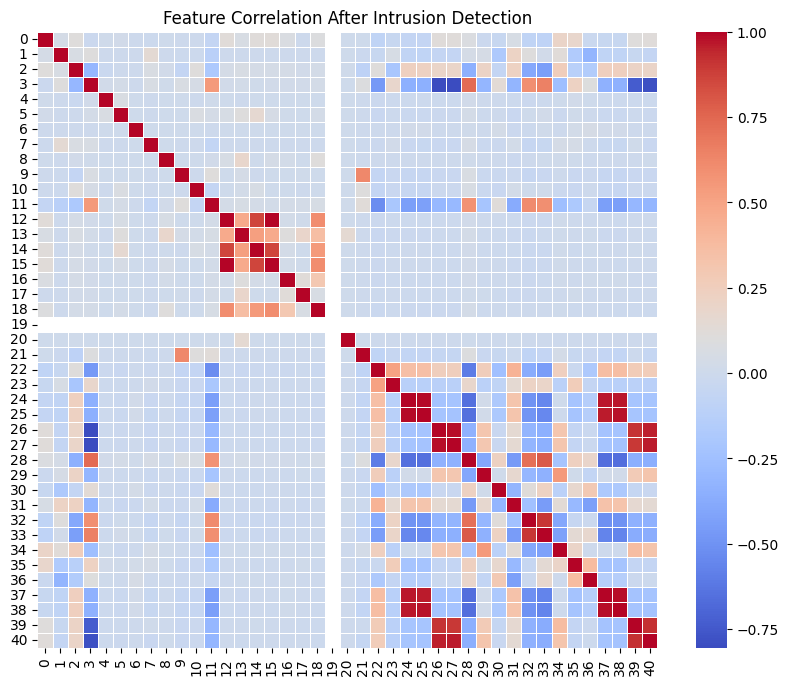


✅ Ensemble Model Accuracy: 98.73%

📊 Simplified Classification Report:

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        39
           1      1.000     1.000     1.000        28
           2      1.000     0.167     0.286         6
           4      1.000     0.987     0.993        77
           5      1.000     1.000     1.000         5
           6      1.000     0.000     0.000         1
           7      1.000     0.964     0.982        56
           8      1.000     0.000     0.000         2
           9      1.000     0.000     0.000         1
          10      1.000     1.000     1.000        14
          11      1.000     0.976     0.988        42
          13      1.000     1.000     1.000         1
          14      0.996     1.000     0.998      1043
          15      0.970     1.000     0.985        32
          16      0.982     0.997     0.990      1663
          19      1.000     1.000     1.000         6
        

In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Suppress warnings
warnings.filterwarnings("ignore")

# Load Dataset
file_path = "/content/kdd_test.csv.zip"  # Update with correct path
df = pd.read_csv(file_path)

# Define target column
target_col = "labels"

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Handle missing data
df.dropna(inplace=True)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Analyze class distribution
class_dist = Counter(y)
min_samples = min(class_dist.values())

# Apply SMOTE for class balancing
if min_samples > 2:
    smote_instance = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=5)
    X_resampled, y_resampled = smote_instance.fit_resample(X_scaled, y)
else:
    X_resampled, y_resampled = X_scaled, y

# Re-encode target after SMOTE
y_resampled = label_encoder.fit_transform(y_resampled)

# Ensure stratification
min_class_count = min(Counter(y_resampled).values())
stratify_option = y_resampled if min_class_count > 1 else None

# Split data before SMOTE
X_train_before, X_test_before, y_train_before, y_test_before = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42, stratify=stratify_option, shuffle=True
)

# Split data after SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=stratify_option, shuffle=True
)

# Feature Selection with RFE
rf_base = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
rfe_model = RFE(rf_base, n_features_to_select=int(0.75 * X_train.shape[1]), step=5)
X_train_selected = rfe_model.fit_transform(X_train, y_train)
X_test_selected = rfe_model.transform(X_test)

# Get and display selected features
selected_features = X.columns[rfe_model.support_].tolist()
print("\n📋 Top Selected Features by RFE:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Define and configure individual models
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=28, min_samples_split=2, random_state=42, n_jobs=-1)
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.015, max_depth=9, random_state=42)
xgb_clf = XGBClassifier(n_estimators=300, learning_rate=0.015, max_depth=11, eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1)
lgbm_clf = LGBMClassifier(n_estimators=300, learning_rate=0.015, max_depth=12, random_state=42, n_jobs=-1)

# Ensemble model with optimized weights
ensemble_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf)],
    voting='soft',
    weights=[1, 1, 7, 7],  # Emphasize boosting models
    n_jobs=-1
)

# Visualization functions
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

def plot_feature_heatmap(data, title):
    corr_matrix = pd.DataFrame(data).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title(title)
    plt.show()

# Before Intrusion Detection (Before SMOTE)
rf_clf.fit(X_train_before, y_train_before)
y_pred_before = rf_clf.predict(X_test_before)
print("\n🔵 Confusion Matrix Before SMOTE (Imbalanced Data):")
plot_confusion_matrix(y_test_before, y_pred_before, "Before Intrusion Detection")

# Train and predict with ensemble (After SMOTE)
ensemble_clf.fit(X_train_selected, y_train)
y_pred_ensemble = ensemble_clf.predict(X_test_selected)

# After Intrusion Detection (After SMOTE)
print("\n🟢 Confusion Matrix After SMOTE (Balanced Data):")
plot_confusion_matrix(y_test, y_pred_ensemble, "After Intrusion Detection")

# Feature Correlation Heatmaps
print("\n🔵 Feature Correlation Heatmap Before Intrusion Detection:")
plot_feature_heatmap(X_scaled, "Feature Correlation Before Intrusion Detection")

print("\n🟢 Feature Correlation Heatmap After Intrusion Detection:")
plot_feature_heatmap(X_resampled, "Feature Correlation After Intrusion Detection")

# Evaluate accuracy
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"\n✅ Ensemble Model Accuracy: {ensemble_accuracy * 100:.2f}%")

# Classification report
print("\n📊 Simplified Classification Report:\n")
print(classification_report(y_test, y_pred_ensemble, zero_division=1, digits=3))

In [ ]:
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings (like those from XGBoost and LightGBM)
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings (e.g., deprecated warnings)

# Extract zip file
with zipfile.ZipFile("/content/kdd_test.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Load the dataset (skip the first row with column names)
test_path = "/content/kdd_test.csv"
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Load data and skip the first row (it contains column names)
data = pd.read_csv(test_path, header=None, names=col_names, skiprows=1)

# Display a sample to verify
print("Sample rows from dataset:")
print(data.head())

# Prepare the features and target
data["label"] = data["label"].apply(lambda x: "normal" if x == "normal" else "attack")
X = data.drop(columns=["label", "difficulty"])
y = data["label"]

# Encode categorical features
for col in ["protocol_type", "service", "flag"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode the target labels as numeric (0 for 'normal', 1 for 'attack')
y = y.map({"normal": 0, "attack": 1})

# Final shape check
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

# Train-test split (using the same dataset as train and test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boost": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    print(f"\n{name} Results:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_test_bin = y_test

    print("Classification Report:")
    print(classification_report(y_test_bin, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_bin, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test_bin, y_prob):.4f}")


Sample rows from dataset:
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         5           tcp      smtp    SF       2429        475     0   
1         0           udp  domain_u    SF         45        134     0   
2         0           udp  domain_u    SF         45         80     0   
3      1979           udp     other    SF        145        105     0   
4     14462           tcp     other  RSTR          1          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.11   
1               0       0    0  ...                    0.80   
2               0       0    0  ...                    1.00   
3               0       0    0  ...                    0.01   
4               0       0    0  ...                    0.01   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.02                         0.01   
1                    0.02               

In [ ]:
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings (like those from XGBoost and LightGBM)
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings (e.g., deprecated warnings)

# Extract zip file
with zipfile.ZipFile("/content/kdd_test.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Load the dataset (skip the first row with column names)
test_path = "/content/kdd_test.csv"
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Load data and skip the first row (it contains column names)
data = pd.read_csv(test_path, header=None, names=col_names, skiprows=1)

# Display a sample to verify
print("Sample rows from dataset:")
print(data.head())

# Prepare the features and target
data["label"] = data["label"].apply(lambda x: "normal" if x == "normal" else "attack")
X = data.drop(columns=["label", "difficulty"])
y = data["label"]

# Encode categorical features
for col in ["protocol_type", "service", "flag"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode the target labels as numeric (0 for 'normal', 1 for 'attack')
y = y.map({"normal": 0, "attack": 1})

# Final shape check
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

# Train-test split (using the same dataset as train and test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boost": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Initialize an empty list to store the results
results = []

# Train and evaluate models
for name, model in models.items():
    print(f"\n{name} Results:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_test_bin = y_test

    # Classification report as dataframe
    class_report = classification_report(y_test_bin, y_pred, digits=4, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_bin, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, columns=["Pred Normal", "Pred Attack"], index=["True Normal", "True Attack"])

    # ROC-AUC score
    roc_auc = roc_auc_score(y_test_bin, y_prob)

    # Add results to the list
    results.append({
        "Model": name,
        "Accuracy": class_report["accuracy"],
        "Precision (Normal)": class_report["0"]["precision"],
        "Recall (Normal)": class_report["0"]["recall"],
        "F1-Score (Normal)": class_report["0"]["f1-score"],
        "Precision (Attack)": class_report["1"]["precision"],
        "Recall (Attack)": class_report["1"]["recall"],
        "F1-Score (Attack)": class_report["1"]["f1-score"],
        "ROC-AUC": roc_auc
    })

    # Display the classification report and confusion matrix
    print("Classification Report:")
    print(class_report_df)
    print("\nConfusion Matrix:")
    print(conf_matrix_df)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Create a dataframe to summarize all model results
summary_df = pd.DataFrame(results)

# Display the summary table
print("\nSummary of Results:")
print(summary_df)


Sample rows from dataset:
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         5           tcp      smtp    SF       2429        475     0   
1         0           udp  domain_u    SF         45        134     0   
2         0           udp  domain_u    SF         45         80     0   
3      1979           udp     other    SF        145        105     0   
4     14462           tcp     other  RSTR          1          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.11   
1               0       0    0  ...                    0.80   
2               0       0    0  ...                    1.00   
3               0       0    0  ...                    0.01   
4               0       0    0  ...                    0.01   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.02                         0.01   
1                    0.02               

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import zipfile
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Extract zip file
with zipfile.ZipFile("/content/kdd_test.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Column names
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Load data
data = pd.read_csv("/content/kdd_test.csv", header=None, names=col_names, skiprows=1)
data["label"] = data["label"].apply(lambda x: "normal" if x == "normal" else "attack")

X = data.drop(columns=["label", "difficulty"])
y = data["label"].map({"normal": 0, "attack": 1})

# Encode categorical
for col in ["protocol_type", "service", "flag"]:
    X[col] = LabelEncoder().fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boost": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Get accuracies
accuracy_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append({"Model": name, "Accuracy": round(accuracy, 4)})

# Show results in table
accuracy_df = pd.DataFrame(accuracy_results)
print("\nModel Accuracies:\n")
print(accuracy_df.to_string(index=False))


[LightGBM] [Info] Number of positive: 7909, number of negative: 7909
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2907
[LightGBM] [Info] Number of data points in the train set: 15818, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Model Accuracies:

         Model  Accuracy
 Random Forest    0.9911
Gradient Boost    0.9823
       XGBoost    0.9914
      LightGBM    0.9925
